# 节点重要性排序和评估


导入包。


In [5]:
import json

import numpy as np
import matplotlib.pyplot as plt

`load_networks` 函数加载若干个网络的邻接矩阵表示。


In [6]:
def load_networks():
    with open("networks.json", "r") as file:
        return json.load(file)

`simulate_SIR` 函数使用 SIR 模型模拟传播过程。

在一个社交网络中，存在一些初始的感染者。每个感染者以概率 β 感染其邻居，以概率 γ 康复。

函数返回各状态在各时间点上的节点数量。


In [7]:
def simulate_SIR(
    network: list[list[0 | 1]],
    initial_infected_nodes: set[int] = {0},
    beta: float = 0.3,
    gamma: float = 0.1,
):
    # 初始化各节点的状态。
    susceptible_nodes = set(range(len(network))) - initial_infected_nodes
    infected_nodes = initial_infected_nodes
    recovered_nodes = set()

    # 记录各状态在各时间点上的节点数量。
    records = {
        "susceptible": [len(susceptible_nodes)],
        "infected": [len(infected_nodes)],
        "recovered": [len(recovered_nodes)],
    }

    # 如果还有感染者，就会继续传播。
    while infected_nodes:
        # 记录本轮新感染和新康复的节点。
        new_infected_nodes = set()
        new_recovered_nodes = set()

        # 对于每个感染者来说：
        for infected_node in infected_nodes:
            # 他会以概率 β 感染其邻居。
            neighbors = np.nonzero(network[infected_node])[0]
            susceptible_neighbors = set(neighbors) & susceptible_nodes
            for susceptible_neighbor in susceptible_neighbors:
                if np.random.rand() < beta:
                    new_infected_nodes.add(susceptible_neighbor)

            # 他会以概率 γ 康复。
            if np.random.rand() < gamma:
                new_recovered_nodes.add(infected_node)

        # 更新各节点状态。
        susceptible_nodes -= new_infected_nodes
        infected_nodes = (infected_nodes | new_infected_nodes) - new_recovered_nodes
        recovered_nodes |= new_recovered_nodes

        # 记录各状态在当前时间点上的节点数量。
        records["susceptible"].append(len(susceptible_nodes))
        records["infected"].append(len(infected_nodes))
        records["recovered"].append(len(recovered_nodes))

    return records

`show_SIR` 函数绘制 SIR 传播过程中，各状态在各时间点上的节点数量的堆积面积图。


In [8]:
def show_SIR(records: dict[str, list[int]]):
    num_days = len(records["infected"])
    plt.stackplot(
        range(num_days),
        records.values(),
        labels=records.keys(),
        colors=["blue", "red", "green"],
        alpha=0.6,
    )
    plt.title("SIR Propagation")
    plt.xlabel("Days")
    plt.ylabel("Number")
    plt.margins(x=0, y=0)
    plt.legend()
    plt.show()

运行。


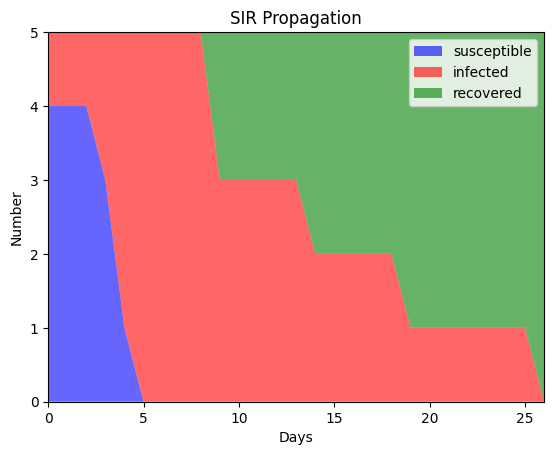

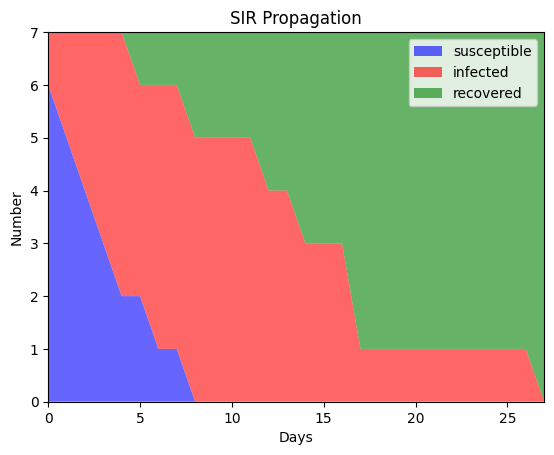

In [9]:
networks = load_networks()

for network in networks:
    records = simulate_SIR(network)
    show_SIR(records)

`load_sequence_pairs` 函数加载若干个序列对。


In [10]:
def load_sequence_pairs():
    with open("sequence-pairs.json", "r") as file:
        return json.load(file)

`calculate_correlation` 函数计算两个序列的相关性系数。


In [11]:
def calculate_correlation(sequence1: list[int], sequence2: list[int]):
    assert len(sequence1) == len(sequence2)

    pairs = list(zip(sequence1, sequence2))
    num_positive = 0
    num_negative = 0

    for index, (x1, y1) in enumerate(pairs[:-1]):
        for x2, y2 in pairs[index + 1 :]:
            if (x1 < x2 and y1 < y2) or (x1 > x2 and y1 > y2):
                num_positive += 1
            elif (x1 < x2 and y1 > y2) or (x1 > x2 and y1 < y2):
                num_negative += 1

    correlation = (num_positive - num_negative) / sum(range(len(sequence1)))
    return correlation

运行。


In [12]:
sequence_pairs = load_sequence_pairs()

for index, pair in enumerate(sequence_pairs):
    correlation = calculate_correlation(pair[0], pair[1])
    print(f"Pair {index} correlation: {correlation}")

Pair 0 correlation: 1.0
Pair 1 correlation: -0.4


In [58]:
def calculate_k_shell_index(network: list[list[0 | 1]]):
    # 将网络转换为 NumPy 数组，便于处理。
    network = np.asarray(network, dtype=float)

    # 初始化每个节点的度数。
    degrees = np.asarray([sum(row) for row in network])

    # 初始化每个节点的 k-shell 等级。
    shell_levels = np.zeros_like(degrees)

    # 如果还有节点没有被移除，就继续。
    while degrees.min() < np.inf:
        # 找到度数最小的节点。
        min_degree = degrees.min()
        min_degree_nodes = np.nonzero(degrees == min_degree)[0]

        # 将这些节点从网络中移除。
        network[:, min_degree_nodes] = 0
        network[min_degree_nodes, :] = np.inf

        # 更新每个节点的度数。
        degrees = np.asarray([sum(row) for row in network])

        # 更新每个节点的 k-shell 等级。
        shell_levels[min_degree_nodes] = min_degree

    return shell_levels.astype(int).tolist()

In [59]:
calculate_k_shell_index(networks[1])

[3, 3, 3, 3, 2, 2, 1]